# Load data

In [1]:
!pip install wget
!pip install --upgrade keras
!pip install tensorflow==2.0
import wget

wget.download('https://github.com/belerico/unimib/raw/master/advanced machine learning/assignment 2/data/x_test.obj', './x_test.obj')
wget.download('https://github.com/belerico/unimib/raw/master/advanced machine learning/assignment 2/data/y_train.obj', './y_train.obj')
wget.download('https://github.com/belerico/unimib/raw/master/advanced machine learning/assignment 2/data/x_train.obj', './x_train.obj')

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=d8f5b58cdc1cb271a6d83f37f760a018ce36b191d5ff02d47319a98291eb0aea
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 378kB 4.9MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5
     |████████████████████████████████| 86.3MB 124kB/s 
     |████████████████████████████████| 3.8MB 40.3MB/s 
     |████████████████████████████████| 450kB 51.2MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:


'./x_train.obj'

In [0]:
import numpy as np
import keras

In [3]:
import pickle
from keras import utils

with open('./x_train.obj', 'rb') as f:
  dataset = pickle.load(f)
  dataset = dataset.astype('float32') / 255.
  dataset = dataset.reshape(dataset.shape[0], -1)

with open('./x_test.obj', 'rb') as f:
  x_test = pickle.load(f)
  x_test = x_test.astype('float32') / 255.
  x_test = x_test.reshape(x_test.shape[0], -1)

with open('./y_train.obj', 'rb') as f:
  y_dataset = pickle.load(f)
  # Label from 0 to 11
  y_dataset -= 16
  # y_dataset = utils.to_categorical(y_dataset)

N_IMG = dataset.shape[0]
N_CLASSES = 11
IMG_SHAPE = dataset.shape[1]

# Split train and val
import random

indexes = np.arange(N_IMG)
# random.seed(42)
random.shuffle(indexes)
train_val_split = int(N_IMG * 0.8)

x_train = dataset[indexes[:train_val_split], :]
y_train = y_dataset[indexes[:train_val_split]]

x_val = dataset[indexes[train_val_split:], :]
y_val = y_dataset[indexes[train_val_split:]]

# Standardize to get gaussian

mean = np.mean(x_train)
std = np.std(x_train)

print(f"Mean {mean} and std {std}")

Mean 0.17248839139938354 and std 0.3312186598777771


In [10]:
np.unique(x_train
         )

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313726, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.07450981,
       0.07843138, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196079, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941177, 0.13333334,
       0.13725491, 0.14117648, 0.14509805, 0.14901961, 0.15294118,
       0.15686275, 0.16078432, 0.16470589, 0.16862746, 0.17254902,
       0.1764706 , 0.18039216, 0.18431373, 0.1882353 , 0.19215687,
       0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
       0.21568628, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
       0.23529412, 0.23921569, 0.24313726, 0.24705882, 0.2509804 ,
       0.25490198, 0.25882354, 0.2627451 , 0.26666668, 0.27058825,
       0.27450982, 0.2784314 , 0.28235295, 0.28627452, 0.29019

In [9]:
x_val.shape
x_train.shape

(11200, 784)

# Autoencoder and classifier

## Custom layers

In [0]:
from keras import backend as K
from keras.layers import Layer
from keras import regularizers
from keras import losses

class SaltPepperNoise(Layer):
  
  def __init__(self, ratio=0.5, **kwargs):
    super(SaltPepperNoise, self).__init__(**kwargs)
    self.ratio = ratio

  def call(self, inputs, training=None):
    def noised():
      shp = K.shape(inputs)[1:] # input shape
      mask_select = K.random_binomial(shape=shp, p=self.ratio)
      mask_noise = K.random_binomial(shape=shp, p=0.5) # salt and pepper have the same chance
      out = inputs * (1-mask_select) + mask_noise * mask_select
      return out
    
    return K.in_train_phase(noised(), inputs, training=training)
  
  
class StandardizeLayer(Layer):
  
  def __init__(self, mean, std, **kwargs):
    super(StandardizeLayer, self).__init__(**kwargs)
    self.mean = mean
    self.std = std


  def call(self, inputs, training=None):
     return (inputs - self.mean) / self.std

    
class KLDivergenceRegulizer(regularizers.Regularizer):
  
  def __init__(self, weight, target=0.1):
    self.weight = weight
    self.target = target
    
  def call(self, inputs):
     mean_activities = K.mean(inputs, axis=0)
     return self.weight * ( losses.kullback_leibler_divergence(self.target, mean_activities) +
                            losses.kullback_leibler_divergence(1. - self.target, 1- mean_activities) )
    



In [0]:
#noise_factor = 0.2
#x_train = x_train (1 - noise_factor) + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
#x_test = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
#x_val = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 

#x_train = np.clip(x_train, 0., 1.)
#x_test = np.clip(x_test, 0., 1.)
#x_val = np.clip(x_val, 0., 1.)

In [0]:
import tensorflow as tf

# Models and training

In [0]:
from keras.models import Model
from keras import layers
from keras import regularizers
from keras import losses
from keras import models
from keras.metrics import categorical_accuracy

def rmse(y_true, y_pred):
  return K.sqrt(losses.mse(y_true, y_pred))

# Neural Network
def get_model(
    model_type='nn',
    divide_by=2,
    hidden_first=256,
    hidden_last=64,
    dropout=True, 
    dropout_rate=0.3,
    batch_norm=False, 
    standard=False,
    noise_type=None,
    salt_pepper_noise_ratio=0.3, 
    gaussian_noise_std=0.5,
    regulizer=None,
    verbose=True
):
  print(f"noise: {noise_type} standardized: {standard}")
  
  classifier_metrics = ['accuracy']
  input_layer = layers.Input(shape=(IMG_SHAPE, ))
  if model_type == 'autoencoder' or model_type == 'autoencoder_nn':
    
    if noise_type is not None:
      # noisy layer
      if noise_type == 'gaussian':  # Gaussian
        noise_layer = layers.GaussianNoise(gaussian_noise_std)(input_layer)
      if noise_type == 'saltpepper':  # Salt and pepper
        noise_layer = SaltPepperNoise(ratio=salt_pepper_noise_ratio)(input_layer)
      encode = layers.Dense(hidden_first, activation ="selu", kernel_initializer="lecun_normal")(noise_layer)
    else:
      encode = layers.Dense(hidden_first, activation ="selu", kernel_initializer="lecun_normal")(input_layer)
    
    if standard:  # Gaussian
        encode = StandardizeLayer(mean, std)(encode)
    
    # encoder
    saved_hidden_first = hidden_first
    while hidden_first > hidden_last * divide_by:
      hidden_first = int(hidden_first / divide_by)
      encode = layers.Dense(hidden_first, activation ="selu", kernel_initializer="lecun_normal")(encode)
    # , activity_regularizer=regularizers.l1(1e-5)
    encode = layers.Dense(hidden_last, activation ="selu", activity_regularizer=regulizer, kernel_initializer="lecun_normal", name='encoder')(encode)
    encoder = Model(inputs=input_layer, outputs=encode)
    
    # decoder
    hidden_last *= divide_by
    decode = layers.Dense(hidden_last, activation='selu')(encode) 
    while saved_hidden_first > hidden_last:
      hidden_last *= divide_by
      decode = layers.Dense(hidden_last, kernel_initializer="lecun_normal", activation='selu')(decode)  
    decode = layers.Dense(IMG_SHAPE, activation='sigmoid', name='decoder')(decode)
    
    outputs = [decode]
    if model_type == 'autoencoder_nn':
      # classifier
      classifier = layers.Dense(N_CLASSES, activation="softmax", name='classifier')(encode)
      outputs.insert(0, classifier)
    
    # model
    model = Model(inputs=input_layer, outputs=outputs)
    
    if len(outputs) > 1:
      loss = ["sparse_categorical_crossentropy", 'mse']
      metrics = {'classifier': classifier_metrics, 'decoder': 'mse'}
    else:
      loss = 'binary_crossentropy'
      metrics = {}
      
  elif model_type == 'nn':
    encode = layers.Dense(hidden_first, activation="relu", kernel_initializer="he_normal")(input_layer)
    if batch_norm:
      encode = layers.BatchNormalization()(encode)
    if dropout:
      encode = layers.Dropout(dropout_rate)(encode)
    while hidden_first > hidden_last:
      hidden_first = int(hidden_first / divide_by)
      encode = layers.Dense(hidden_first, activation="relu", kernel_initializer="he_normal")(encode)
      if batch_norm:
        encode = layers.BatchNormalization()(encode)
      if dropout:
        encode = layers.Dropout(dropout_rate)(encode) 
    
    classifier = layers.Dense(N_CLASSES, activation="softmax", name='classifier')(encode)
    # nn model
    model = Model(inputs=input_layer, outputs=classifier)
    encoder = None
    loss = "sparse_categorical_crossentropy"
    metrics = {'classifier': classifier_metrics}
  
  # print(metrics)
  model.compile(optimizer="rmsprop", loss=loss, metrics=metrics)
  if verbose:
    model.summary()
  # print(model.metrics_names)
  
  return model, encoder

# Plain neural network

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

monitor = 'val_loss'
early_stopping = EarlyStopping(monitor=monitor, patience=10, min_delta=0.001, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=10, verbose=1)
callbacks = [early_stopping]

In [17]:
from sklearn.model_selection import KFold

model_type = 'nn'


if model_type == 'autoencoder_nn':
  labels_train = [y_train, x_train]
  labels_val = [y_val, x_val]
elif model_type == 'nn':
  labels_train = y_train
  labels_val = y_val
elif model_type == 'autoencoder':
  labels_train = x_train
  labels_val = x_val

# define 10-fold cross validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores_val = []
best_score = 0  # based on accuracy
best_model = None
best_history = None

for idx, (train, val) in enumerate(kfold.split(x_train, labels_train)):
  print('FOLD: ', idx + 1)
  # create model
  model, _ = get_model(
      model_type=model_type, 
      divide_by=2, 
      hidden_first=512, 
      hidden_last=32, 
      dropout=True, 
      noise_type=None,
      batch_norm=True, 
      standard=False, 
      verbose=False
  )
  # Fit the model
  history = model.fit(
      x_train[train], 
      labels_train[train], 
      validation_data=(x_train[val], labels_train[val]), 
      epochs=300, 
      batch_size=128, 
      callbacks=callbacks,
      verbose=2
  )
  # evaluate the model
  score = model.evaluate(x_val, labels_val, verbose=0)
  # save best_model
  if score[1] > best_score:  # accuracy
    best_score = score[1]
    best_model = model
    best_history = history
  print('Performance on the validation set')
  for idx in range(len(model.metrics_names)):
    print("%s: %.2f" % (model.metrics_names[idx], score[idx]))
  print()
  scores_val.append(score)
  
scores_val = np.array(scores_val)
overall_means = np.mean(scores_val, axis=0)
overall_stds = np.std(scores_val, axis=0)
for idx in range(len(overall_means)):
  print('Overall ', model.metrics_names[idx], ': ', '{:.2f}'.format(overall_means[idx]), '+-', '{:.2f}'.format(overall_stds[idx]))

FOLD:  1
noise: None standardized: False
Train on 10080 samples, validate on 1120 samples
Epoch 1/300
 - 2s - loss: 1.7460 - accuracy: 0.4358 - val_loss: 1.0649 - val_accuracy: 0.7125
Epoch 2/300
 - 2s - loss: 1.0055 - accuracy: 0.6972 - val_loss: 0.5921 - val_accuracy: 0.8313
Epoch 3/300
 - 2s - loss: 0.7080 - accuracy: 0.7974 - val_loss: 0.4408 - val_accuracy: 0.8661
Epoch 4/300
 - 2s - loss: 0.5370 - accuracy: 0.8493 - val_loss: 0.3686 - val_accuracy: 0.8955
Epoch 5/300
 - 2s - loss: 0.4401 - accuracy: 0.8800 - val_loss: 0.3053 - val_accuracy: 0.9152
Epoch 6/300
 - 2s - loss: 0.3570 - accuracy: 0.9010 - val_loss: 0.3207 - val_accuracy: 0.9045
Epoch 7/300
 - 2s - loss: 0.3394 - accuracy: 0.9102 - val_loss: 0.3057 - val_accuracy: 0.9134
Epoch 8/300
 - 2s - loss: 0.2946 - accuracy: 0.9183 - val_loss: 0.3145 - val_accuracy: 0.9286
Epoch 9/300
 - 2s - loss: 0.2761 - accuracy: 0.9247 - val_loss: 0.2938 - val_accuracy: 0.9232
Epoch 10/300
 - 2s - loss: 0.2533 - accuracy: 0.9288 - val_loss:

KeyboardInterrupt: ignored

17


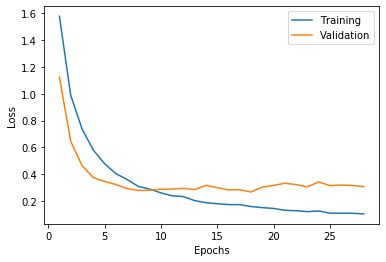

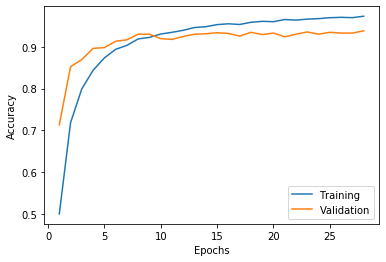

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plot = list(range(1, len(best_model.history.history['val_accuracy']) + 1))

def plot_history(history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, best_model.history.history['loss'])
    plt.plot(x_plot, best_model.history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, best_model.history.history['accuracy'])
    plt.plot(x_plot, best_model.history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

print(len(history.history['val_accuracy']))
plot_history(history)

In [16]:
from sklearn.metrics import classification_report

# labels_val_from_categorical = np.argmax(labels_val, axis=1)
predictions = np.argmax(best_model.predict(x_val), axis=1)
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       243
           1       0.92      0.95      0.93       245
           2       0.93      0.94      0.93       278
           3       0.99      0.97      0.98       252
           4       0.94      0.95      0.94       287
           5       0.92      0.91      0.91       274
           6       0.90      0.86      0.88       257
           7       0.97      0.95      0.96       262
           8       0.97      0.95      0.96       268
           9       0.88      0.90      0.89       261
          10       0.94      0.96      0.95       173

    accuracy                           0.94      2800
   macro avg       0.94      0.94      0.94      2800
weighted avg       0.94      0.94      0.94      2800



In [55]:
predictions = np.argmax(best_model.predict(x_test), axis=1)
predictions = predictions+ 16
print(predictions)

[22 26 25 ... 22 23 20]


In [0]:
np.unique(predictions)
np.savetxt(f'consegna.txt', predictions, fmt='%1.0f')

# Autoencoder

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

monitor = 'val_loss'
early_stopping = EarlyStopping(monitor=monitor, patience=10, min_delta=0.001, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=10, verbose=1)
callbacks = [early_stopping]

In [43]:
model_type = 'autoencoder_nn'

if model_type == 'autoencoder_nn':
  labels_train = [y_train, x_train]
  labels_val = [y_val, x_val]
elif model_type == 'nn':
  labels_train = y_train
  labels_val = y_val
elif model_type == 'autoencoder':
  labels_train = x_train
  labels_val = x_val

autoencoder, encoder = get_model(
    model_type=model_type, 
    hidden_first=512, 
    hidden_last=64, 
    noise_type='gaussian', 
    dropout=False, 
    batch_norm=False, 
    standard=False, 
    verbose=True,
    regulizer=None
)
history_autoencoder = autoencoder.fit(
    x_train, 
    labels_train,
    validation_data=(x_val, labels_val), 
    epochs=300, 
    batch_size=256, 
    callbacks=callbacks
)

noise: gaussian standardized: False
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
gaussian_noise_5 (GaussianNoise (None, 784)          0           input_22[0][0]                   
__________________________________________________________________________________________________
dense_83 (Dense)                (None, 512)          401920      gaussian_noise_5[0][0]           
__________________________________________________________________________________________________
dense_84 (Dense)                (None, 256)          131328      dense_83[0][0]                   
_______________________________________________________

In [0]:

# labels_val_from_categorical = np.argmax(labels_val, axis=1)
predictions, _ = autoencoder.predict(x_val)
print(classification_report(y_val, np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       265
           1       0.94      0.89      0.91       247
           2       0.95      0.92      0.93       286
           3       0.98      0.99      0.99       260
           4       0.95      0.95      0.95       281
           5       0.93      0.94      0.93       249
           6       0.90      0.92      0.91       268
           7       0.95      0.96      0.96       269
           8       0.94      0.92      0.93       255
           9       0.91      0.89      0.90       255
          10       0.95      0.98      0.96       165

    accuracy                           0.94      2800
   macro avg       0.94      0.94      0.94      2800
weighted avg       0.94      0.94      0.94      2800



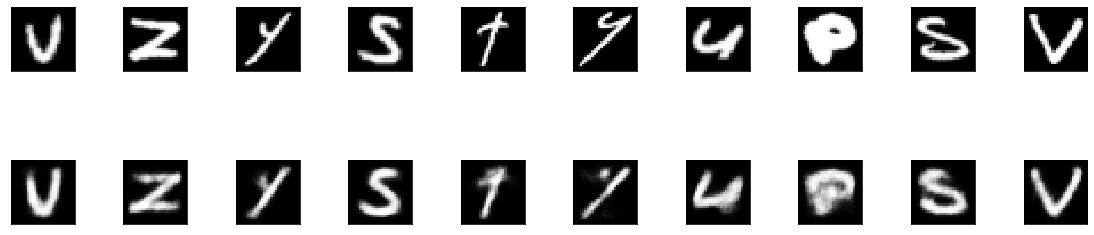

In [44]:
from matplotlib import pyplot as plt
%matplotlib inline

# print accuracy
x_plot = list(range(1, len(history_autoencoder.history['val_loss']) + 1))

def plot_history(histoy_valry):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, history.history['loss'])
    plt.plot(x_plot, history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

#plot_history(history_autoencoder)

# encoded_imgs = encode.predict(x_test)
classes, decoded_imgs = autoencoder.predict(x_test)

n=10
plt.figure(figsize=(40, 4))
for i in range(n):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images
    # ax = plt.subplot(3, 20, i + 1 + 20)
    # plt.imshow(encoded_imgs[i].reshape(8,4))
    # plt.gray()
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
plt.show()

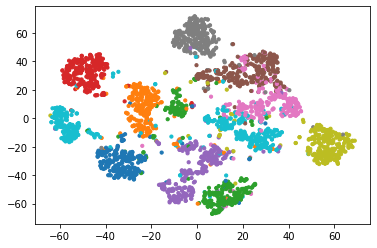

In [45]:
from sklearn.manifold import TSNE

x_val_compressed = encoder.predict(x_val)
tsne = TSNE()
x_val_2d = tsne.fit_transform(x_val_compressed)
plt.scatter(x_val_2d[:, 0], x_val_2d[:, 1], c=y_val, s=10, cmap='tab10')

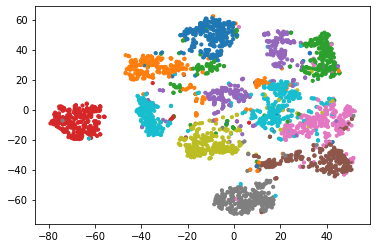

##Tying AE


In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras import losses

In [0]:

class DenseTranspose(layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = tf.keras.activations.get(activation)
    super().__init__(**kwargs)
  
  def build(self, batch_input_shape):
    self.biases = self.add_weight(name='bias', initializer='zeros',
                                 shape=[self.dense.input_shape[-1]])
    
    super().build(batch_input_shape)
    
    
  def call(self, inputs):
    print(self.dense.weights[0])
    z = inputs @ K.transpose(self.dense.weights[0]) 
    return self.activation(z + self.biases)
  
class KLDivergenceRegulizer(regularizers.Regularizer):
  
  def __init__(self, weight, target=0.1):
    self.weight = weight
    self.target = target
    
  def call(self, inputs):
     mean_activities = K.mean(inputs, axis=0)
     return tf.multiply(self.weight, ( tf.add(
         losses.kullback_leibler_divergence(self.target, mean_activities),
                            losses.kullback_leibler_divergence(1. - self.target, 1- mean_activities)) ) )
    

In [0]:
monitor = 'loss'
early_stopping = EarlyStopping(monitor=monitor, patience=10, min_delta=0.001, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=10, verbose=1)
callbacks = [early_stopping]

In [0]:
import tensorflow as tf

In [28]:

d1 = layers.Dense(128, activation='selu', input_shape=(IMG_SHAPE, ) )
d2 = layers.Dense(64, activation='selu')
d3 = layers.Dense(32, activation='selu')
d4 = layers.Dense(16, activation='selu')
encode = Sequential([d1, d2, d3, d4])
t1 = DenseTranspose(d4, activation='selu')
t2 = DenseTranspose(d3, activation='selu')
t3 = DenseTranspose(d2, activation='selu')
t4 = DenseTranspose(d1, activation='sigmoid')

decode = Sequential([t1, t2, t3, t4])
ae = Sequential([d1, d2, d3, d4, t1, t2, t3, t4])
ae.compile(optimizer="adam", loss='mse', metrics=['mse'])

<tf.Variable 'dense_15_1/kernel:0' shape=(32, 16) dtype=float32>
<tf.Variable 'dense_14_1/kernel:0' shape=(64, 32) dtype=float32>
<tf.Variable 'dense_13_1/kernel:0' shape=(128, 64) dtype=float32>
<tf.Variable 'dense_12_1/kernel:0' shape=(784, 128) dtype=float32>


In [29]:
for l in decode.layers[4:-1]:
  l.trainable = False
ae.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_transpose_4 (DenseTran (None, 32)                560       
_________________________________________________________________
dense_transpose_5 (DenseTran (None, 64)                2144      
_________________________________________________________________
dense_transpose_6 (DenseTran (None, 128)              

In [30]:
from sklearn.model_selection import KFold


  # Fit the model
history_encoder_ae = ae.fit(
      x_train[train], 
      x_train[train],
      epochs=300, 
      batch_size=64, 
      callbacks=callbacks
  )
  # evaluate the model
score = ae.evaluate(x_val, x_val, verbose=0)
print(score)

Train on 10080 samples
Epoch 1/300
<tf.Variable 'dense_15_1/kernel:0' shape=(32, 16) dtype=float32>
<tf.Variable 'dense_14_1/kernel:0' shape=(64, 32) dtype=float32>
<tf.Variable 'dense_13_1/kernel:0' shape=(128, 64) dtype=float32>
<tf.Variable 'dense_12_1/kernel:0' shape=(784, 128) dtype=float32>
<tf.Variable 'dense_15_1/kernel:0' shape=(32, 16) dtype=float32>
<tf.Variable 'dense_14_1/kernel:0' shape=(64, 32) dtype=float32>
<tf.Variable 'dense_13_1/kernel:0' shape=(128, 64) dtype=float32>
<tf.Variable 'dense_12_1/kernel:0' shape=(784, 128) dtype=float32>
10080/10080 [==============================] - 2s 228us/sample - loss: 0.0834 - mse: 0.0834
Epoch 2/300
10080/10080 [==============================] - 1s 126us/sample - loss: 0.0476 - mse: 0.0476
Epoch 3/300
10080/10080 [==============================] - 1s 122us/sample - loss: 0.0405 - mse: 0.0405
Epoch 4/300
10080/10080 [==============================] - 1s 122us/sample - loss: 0.0366 - mse: 0.0366
Epoch 5/300
10080/10080 [==========

<tf.Variable 'dense_68_1/kernel:0' shape=(32, 16) dtype=float32>
<tf.Variable 'dense_67_1/kernel:0' shape=(64, 32) dtype=float32>
<tf.Variable 'dense_66_1/kernel:0' shape=(128, 64) dtype=float32>
<tf.Variable 'dense_65_1/kernel:0' shape=(784, 128) dtype=float32>


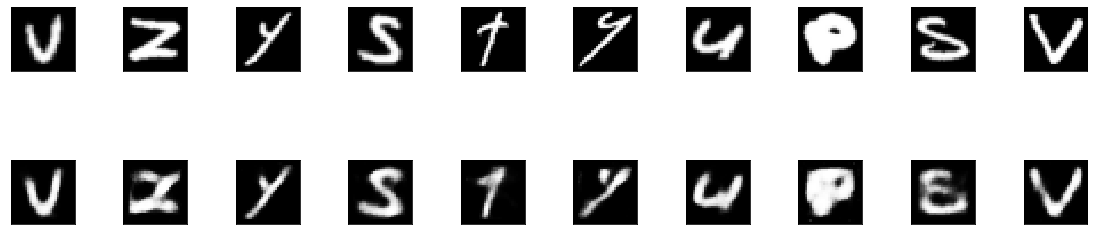

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

# print accuracy
x_plot = list(range(1, len(history_encoder_ae.history['loss']) + 1))

def plot_history(histoy_valry):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, history.history['loss'])
    plt.plot(x_plot, history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

#plot_history(history_autoencoder)

# encoded_imgs = encode.predict(x_test)
decoded_imgs = ae.predict(x_test)

n=10
plt.figure(figsize=(40, 4))
for i in range(n):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images
    # ax = plt.subplot(3, 20, i + 1 + 20)
    # plt.imshow(encoded_imgs[i].reshape(8,4))
    # plt.gray()
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
plt.show()

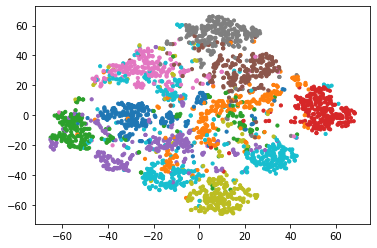

In [0]:
from sklearn.manifold import TSNE

x_val_compressed = encode.predict(x_val)
tsne = TSNE()
x_val_2d = tsne.fit_transform(x_val_compressed)
plt.scatter(x_val_2d[:, 0], x_val_2d[:, 1], c=y_val, s=10, cmap='tab10')